In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('C:/Users/柠檬有点萌/Desktop/machine_learning/wdbc.data', header=None)

In [2]:
#分裂数据集为训练集和测试集
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2].values
Y = df.loc[:, 1].values
le = LabelEncoder()
Y = le.fit_transform(Y)
print(le.classes_)

['B' 'M']


In [3]:
#在阵列Y中对分类标签编码后，检查两个虚拟分类标签的映射
print(le.transform(['M','B']))

[1 0]


In [4]:
#按照8:2的比例把数据分成独立的训练集和测试集
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = \
    train_test_split(X, Y, test_size=0.20, stratify=Y, random_state=1)

In [5]:
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)
Y_train = Y_train.reshape(-1,1)
Y_test = Y_test.reshape(-1,1)

In [7]:
#用make_pipeline函数将多个scikit-learn转换器在管道中链接起来，用管道方法简化工作流

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=1), LogisticRegression(random_state=1))
pipe_lr.fit(X_train, Y_train)
Y_pred = pipe_lr.predict(X_test)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, Y_test))

Test Accuracy: 0.895


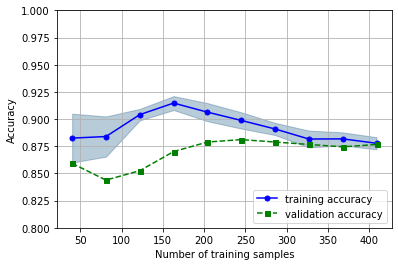

In [8]:
#利用scikit-learn的学习曲线来评估模型

import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', random_state=1))
train_sizes, train_scores, test_scores = \
    learning_curve(estimator=pipe_lr, X=X_train, y=Y_train, train_sizes=np.linspace(0.1,1.0,10), cv=10, n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
#把平均准确度的标准方差加在图上以表示对模型评估的方差
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8,1.0])
plt.show()

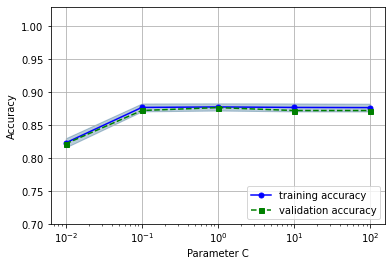

In [9]:
#利用scikit-learn的验证曲线调整模型参数来调优，从而评估模型

from sklearn.model_selection import validation_curve

param_range = [0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = \
    validation_curve(estimator=pipe_lr, X=X_train, y=Y_train, param_name='logisticregression__C', param_range=param_range, cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
#把平均准确度的标准方差加在图上以表示对模型评估的方差
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.7,1.03])
plt.show()

In [10]:
#网格搜索方法来超参数调优

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C':param_range, 'svc__kernel':['linear']}, {'svc__C':param_range, 'svc__gamma':param_range, 'svc__kernel':['rbf']}]
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)
gs = gs.fit(X_train, Y_train)
print(gs.best_params_)
clf = gs.best_estimator_
clf.fit(X_train, Y_train)
print('Test accuracy: %.3f' % clf.score(X_test, Y_test))

UnicodeEncodeError: 'ascii' codec can't encode characters in position 18-20: ordinal not in range(128)

In [11]:
#含混矩阵，展示算法性能指标

from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train, Y_train)
Y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=Y_test, y_pred=Y_pred)
print(confmat)

[[72  0]
 [10 32]]


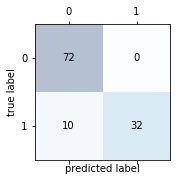

In [13]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i,j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

In [ ]:
#受试者操作特性图ROC，以FPR、TPR的性能比较结果为依据，通过移动分类器的阈值完成计算
#是选择分类模型的有用工具

from sklearn.metrics import roc_curve, auc
from scipy import interp

pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression(penalty='l2', random_state=1, C=100.0))
X_train2 = X_train[:,[4,14]]
cv = list(StratifiedKFold(n_splits=3, random_state=1).split(X_train, Y_train))
fig = plt.figure(figsize=(7,5))
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
for i,(train,test) in enumerate(cv):
    